In [1]:
# Import necessary packages under distinct variable names
import gurobipy as gp
from gurobipy import GRB as gurobi_constant
from gerrychain import Graph as gerrychain_graph
import networkx as nx_library
import geopandas as gpd_library
import math as math_operations

In [ ]:
!pip install gurobipy

In [2]:
!pip install gerrychain

In [3]:
# Specify distinct variable names for the file path and name them
file_path = '/content/'
file_name = 'Arkansas_county.json'

# Create a new Graph object 'graph_obj' from the file
graph_obj =  gerrychain_graph.from_json(file_path + file_name)


In [4]:
# Set the population of each node in 'graph_obj' to the population of their associated county
for node_id in graph_obj.nodes:
    graph_obj.nodes[node_id]['TOTPOP'] = graph_obj.nodes[node_id]['P0010001']

In [5]:
# Print the population of each node in 2020 alongside the county it represents
for node_id in graph_obj.nodes:
    county_name = graph_obj.nodes[node_id]['NAME20']
    population_2020 = graph_obj.nodes[node_id]['TOTPOP']
    print(f"Node {node_id} represents {county_name} County with 2020 population of {population_2020}")

Node 0 represents Franklin County with 2020 population of 17097
Node 1 represents Crawford County with 2020 population of 60133
Node 2 represents Jackson County with 2020 population of 16755
Node 3 represents Clay County with 2020 population of 14552
Node 4 represents Faulkner County with 2020 population of 123498
Node 5 represents Baxter County with 2020 population of 41627
Node 6 represents Little River County with 2020 population of 12026
Node 7 represents Boone County with 2020 population of 37373
Node 8 represents Ashley County with 2020 population of 19062
Node 9 represents Desha County with 2020 population of 11395
Node 10 represents St. Francis County with 2020 population of 23090
Node 11 represents Montgomery County with 2020 population of 8484
Node 12 represents Sharp County with 2020 population of 17271
Node 13 represents Greene County with 2020 population of 45736
Node 14 represents Woodruff County with 2020 population of 6269
Node 15 represents White County with 2020 popul

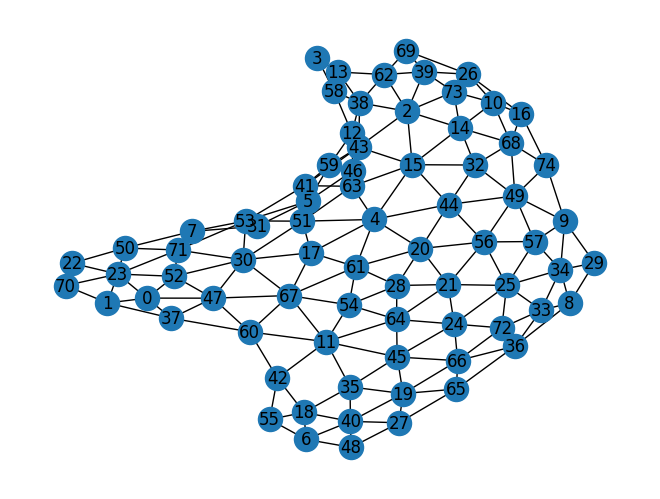

In [11]:
# Build the node graph
nx_library.draw(graph_obj, with_labels=True)

In [12]:
# Assign the greatest deviation/2 * the average population to the model's ceiling and floor
deviation = 0.01

num_partitions = 4
total_population = sum(graph_obj.nodes[node]['TOTPOP'] for node in graph_obj.nodes)

ceiling = math_operations.ceil((1 - deviation/2) * total_population / num_partitions)
floor = math_operations.floor((1 + deviation/2) * total_population / num_partitions)

print(f"Using ceiling = {ceiling}, floor = {floor}, and k = {num_partitions}")


Using ceiling = 749117, floor = 756645, and k = 4


In [13]:
# Create a new model object and variables
model_cut_edges = gp.Model()

node_variables = model_cut_edges.addVars(graph_obj.nodes, num_partitions, vtype=gurobi_constant.BINARY)
edge_variables = model_cut_edges.addVars(graph_obj.edges, vtype=gurobi_constant.BINARY)


Restricted license - for non-production use only - expires 2025-11-24


In [14]:
# Set objective function to minimize cut edges
model_cut_edges.setObjective(gp.quicksum(edge_variables[u, v] for u, v in graph_obj.edges), gurobi_constant.MINIMIZE)

In [15]:
# Each county i is allocated a district j
model_cut_edges.addConstrs(gp.quicksum(node_variables[i, j] for j in range(num_partitions)) == 1 for i in graph_obj.nodes)

# Each district j has a population of at least L and no more than U
model_cut_edges.addConstrs(gp.quicksum(graph_obj.nodes[i]['TOTPOP'] * node_variables[i, j] for i in graph_obj.nodes) >= ceiling for j in range(num_partitions))
model_cut_edges.addConstrs(gp.quicksum(graph_obj.nodes[i]['TOTPOP'] * node_variables[i, j] for i in graph_obj.nodes) <= floor for j in range(num_partitions))

# If u is allocated to district j but v is not, an edge is created
model_cut_edges.addConstrs(node_variables[u, j] - node_variables[v, j] <= edge_variables[u, v] for u, v in graph_obj.edges for j in range(num_partitions))

model_cut_edges.update()


In [16]:
# Add root variables: r[i,j] = 1 if node i is the root of district j

root_variables = model_cut_edges.addVars(graph_obj.nodes, num_partitions, vtype=gurobi_constant.BINARY)

# Create a directed graph based on the original graph
directed_graph = nx_library.DiGraph(graph_obj)

# Add variables for directed edges
edge_variables_directed = model_cut_edges.addVars(directed_graph.edges)


In [17]:
# The big-M suggested by Hojny et al.
big_M = graph_obj.number_of_nodes() - num_partitions + 1

# Every district needs to have only one root
model_cut_edges.addConstrs(gp.quicksum(root_variables[i, j] for i in graph_obj.nodes) == 1 for j in range(num_partitions))

# Node i cannot be the root of district j if it isn't assigned to it
model_cut_edges.addConstrs(root_variables[i, j] <= node_variables[i, j] for i in graph_obj.nodes for j in range(num_partitions))

# Consume some flow if there isn't a root
#  Send out (so much) flow only if there is a root
model_cut_edges.addConstrs(gp.quicksum(edge_variables_directed[j, i] - edge_variables_directed[i, j] for j in graph_obj.neighbors(i))
             >= 1 - big_M * gp.quicksum(root_variables[i, j] for j in range(num_partitions)) for i in graph_obj.nodes)

# Flow should not be sent over cut edges
model_cut_edges.addConstrs(edge_variables_directed[i, j] + edge_variables_directed[j, i] <= big_M * (1 - edge_variables[i, j]) for i, j in graph_obj.edges)

model_cut_edges.update()


In [18]:
# Solve the IP model
model_cut_edges.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1422 rows, 1176 columns and 5748 nonzeros
Model fingerprint: 0xa1a4a853
Variable types: 384 continuous, 792 integer (792 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.03s
Presolved: 1422 rows, 1176 columns, 5748 nonzeros
Variable types: 384 continuous, 792 integer (792 binary)

Root relaxation: objective 0.000000e+00, 602 iterations, 0.04 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  316          -    0.00000      -     -    0s
     0    

In [19]:
# Display the number of cut edges
print("The number of cut edges is", model_cut_edges.objval)

# Retrieve the districts' demography
districts = [[i for i in graph_obj.nodes if node_variables[i, j].x > 0.5] for j in range(num_partitions)]
district_counties = [[graph_obj.nodes[i]["NAME20"] for i in district] for district in districts]
district_populations = [sum(graph_obj.nodes[i]["TOTPOP"] for i in district) for district in districts]

# Print the data
for j in range(num_partitions):
    print("District", j, "has population", district_populations[j], "and contains counties", district_counties[j])
    print("")


The number of cut edges is 33.0
District 0 has population 751754 and contains counties ['Franklin', 'Crawford', 'Benton', 'Madison', 'Sebastian', 'Washington']

District 1 has population 754547 and contains counties ['Little River', 'Ashley', 'Desha', 'Montgomery', 'Howard', 'Nevada', 'Grant', 'Dallas', 'Cleveland', 'Lafayette', 'Chicot', 'Pope', 'Bradley', 'Drew', 'Pike', 'Union', 'Hempstead', 'Polk', 'Clark', 'Logan', 'Miller', 'Arkansas', 'Johnson', 'Garland', 'Sevier', 'Jefferson', 'Lincoln', 'Scott', 'Hot Spring', 'Columbia', 'Ouachita', 'Yell', 'Calhoun', 'Phillips']

District 2 has population 754435 and contains counties ['Jackson', 'Clay', 'Baxter', 'Boone', 'St. Francis', 'Sharp', 'Greene', 'Woodruff', 'White', 'Lee', 'Crittenden', 'Marion', 'Prairie', 'Lawrence', 'Poinsett', 'Stone', 'Independence', 'Fulton', 'Carroll', 'Van Buren', 'Searcy', 'Randolph', 'Izard', 'Craighead', 'Cleburne', 'Monroe', 'Mississippi', 'Newton', 'Cross']

District 3 has population 750788 and contain

In [20]:
# Access the Arkansas county shapefile located at "OK_county.shp"
file_path = '/content/'
file_name = 'Arkansas_county.shp'

# Retrieve the Geopandas dataframe from the file
geopandas_df = gpd_library.read_file(file_path + file_name)


In [21]:
!pip install geopandas

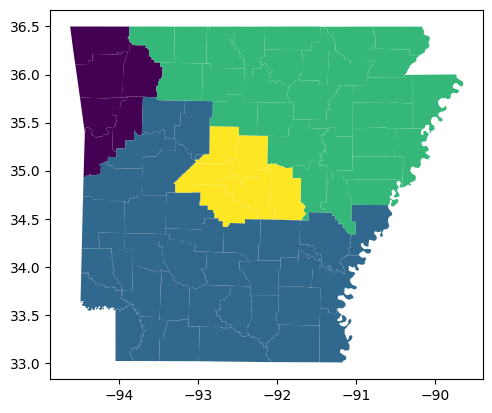

In [22]:
# Which district does each county belong to?
county_assignment = [-1 for i in graph_obj.nodes]

labeling = {i: j for i in graph_obj.nodes for j in range(num_partitions) if node_variables[i, j].x > 0.5}
# Add assignments to a dataframe column and map them
node_with_this_geoid = {graph_obj.nodes[i]['GEOID20']: i for i in graph_obj.nodes}

# Populate the county_assignment list
for u in range(graph_obj.number_of_nodes()):
    geoid = geopandas_df['GEOID20'][u]
    i = node_with_this_geoid[geoid]
    county_assignment[u] = labeling[i]

# Print the congressional district map
geopandas_df['assignment'] = county_assignment
my_fig = geopandas_df.plot(column='assignment').get_figure()
